In [4]:
import pandas as pd
df = pd.read_csv("D:/Download/dataverse_files/web-ids23/web-ids23_portscan.csv")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.


=== DỰ ĐOÁN TRÊN TẬP TEST ===
Đang tải X_test và y_test từ: D:/webids23_processed2/
Đang tải mô hình từ: D:/SinhVien/DHCT/Năm4/Nien Luan Nganh/Nhom01_TQA_NCT_BTP_NHN_HK2_20242025/web-attack-detection/cnn_webids23_model.h5
Đang thực hiện dự đoán...
12257/12257 [==============================] - 23s 2ms/step

=== KẾT QUẢ ĐÁNH GIÁ ===
Accuracy: 0.9697
F1-Score (weighted): 0.9708
Recall (weighted): 0.9697
Precision (weighted): 0.9765
Đã lưu ma trận nhầm lẫn tại: D:/webids23_processed2/confusion_matrix.png


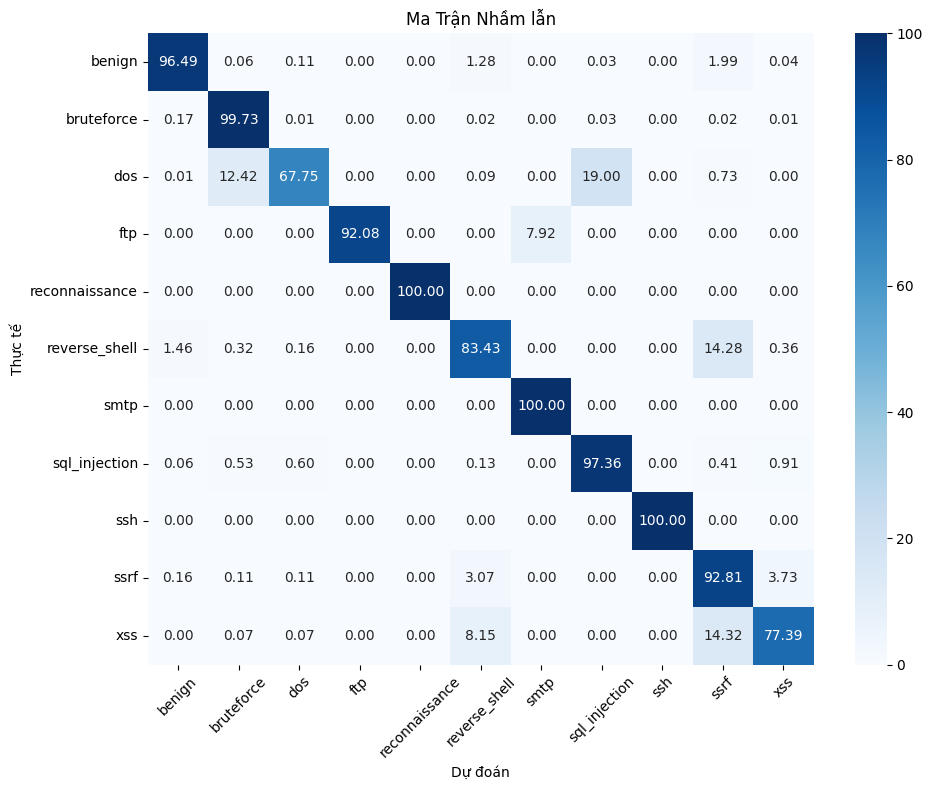


=== BÁO CÁO CHI TIẾT TỪNG LỚP ===
                precision    recall  f1-score   support

        benign       1.00      0.96      0.98    103800
    bruteforce       0.99      1.00      0.99    222486
           dos       0.98      0.68      0.80     17317
           ftp       1.00      0.92      0.96      6338
reconnaissance       1.00      1.00      1.00      1397
 reverse_shell       0.57      0.83      0.68      2535
          smtp       0.67      1.00      0.80      1003
 sql_injection       0.88      0.97      0.93     25985
           ssh       1.00      1.00      1.00      8151
          ssrf       0.37      0.93      0.53      1823
           xss       0.73      0.77      0.75      1362

      accuracy                           0.97    392197
     macro avg       0.83      0.92      0.86    392197
  weighted avg       0.98      0.97      0.97    392197


Dự đoán hoàn tất!


In [ ]:
import numpy as np
import os
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

class WEBIDS23PreprocessorEnhanced:
    def __init__(self):
        self.label_mapping = {}
        self.feature_columns = []

    def predict(self, model_path, save_dir='processed_data'):
        """Dự đoán trên tập test đã lưu và in ma trận nhầm lẫn, các chỉ số đánh giá"""
        print("\n=== DỰ ĐOÁN TRÊN TẬP TEST ===")
        try:
            # Tải dữ liệu test
            print(f"Đang tải X_test và y_test từ: {save_dir}")
            X_test_path = os.path.join(save_dir, 'X_test.npy')
            y_test_path = os.path.join(save_dir, 'y_test.npy')
            metadata_path = os.path.join(save_dir, 'metadata.pkl')
            
            if not os.path.exists(X_test_path) or not os.path.exists(y_test_path):
                raise FileNotFoundError(f"Không tìm thấy X_test.npy hoặc y_test.npy trong {save_dir}")
            if not os.path.exists(metadata_path):
                raise FileNotFoundError(f"Không tìm thấy metadata.pkl trong {save_dir}")
            
            X_test = np.load(X_test_path)
            y_test = np.load(y_test_path)
            
            # Tải metadata để lấy label_mapping
            with open(metadata_path, 'rb') as f:
                metadata = pickle.load(f)
            self.label_mapping = metadata['label_mapping']
            self.feature_columns = metadata['feature_columns']
            class_names = list(self.label_mapping.keys())
            
            # Tải mô hình
            print(f"Đang tải mô hình từ: {model_path}")
            model = load_model(model_path)
            
            # Chuẩn bị dữ liệu
            y_true = np.argmax(y_test, axis=1)  # Chuyển từ one-hot về nhãn số
            
            # Dự đoán
            print("Đang thực hiện dự đoán...")
            y_pred_proba = model.predict(X_test)
            y_pred = np.argmax(y_pred_proba, axis=1)
            
            # Tính toán các chỉ số đánh giá
            accuracy = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average='weighted')
            recall = recall_score(y_true, y_pred, average='weighted')
            precision = precision_score(y_true, y_pred, average='weighted')
            
            # In các chỉ số
            print("\n=== KẾT QUẢ ĐÁNH GIÁ ===")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"F1-Score (weighted): {f1:.4f}")
            print(f"Recall (weighted): {recall:.4f}")
            print(f"Precision (weighted): {precision:.4f}")

            # Tính và hiển thị ma trận nhầm lẫn
            cm = confusion_matrix(y_true, y_pred)
            cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm_percent = np.round(cm_percent * 100, 2)

            plt.figure(figsize=(10, 8))
            sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                        xticklabels=class_names, yticklabels=class_names)

            plt.xlabel('Dự đoán')
            plt.ylabel('Thực tế')
            plt.title('Ma Trận Nhầm lẫn')
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            # Lưu ma trận nhầm lẫn
            cm_save_path = os.path.join(save_dir, 'confusion_matrix.png')
            plt.savefig(cm_save_path)
            print(f"Đã lưu ma trận nhầm lẫn tại: {cm_save_path}")
            plt.show()
            
            # In báo cáo chi tiết cho từng lớp
            print("\n=== BÁO CÁO CHI TIẾT TỪNG LỚP ===")
            print(classification_report(y_true, y_pred, target_names=class_names))
            
            return y_pred, y_pred_proba
        except Exception as e:
            print(f"Lỗi trong quá trình dự đoán: {e}")
            print("\nGợi ý khắc phục:")
            print("1. Kiểm tra đường dẫn model_path có đúng không")
            print("2. Đảm bảo X_test.npy, y_test.npy và metadata.pkl tồn tại trong save_dir")
            print("3. Đảm bảo mô hình tương thích với dữ liệu test (số đặc trưng, số lớp)")
            raise

if __name__ == "__main__":
    preprocessor = WEBIDS23PreprocessorEnhanced()
    try:
        model_path = 'D:/SinhVien/DHCT/Năm4/Nien Luan Nganh/Nhom01_TQA_NCT_BTP_NHN_HK2_20242025/web-attack-detection/lstm_webids23_model.h5'  # Thay bằng đường dẫn thực tế đến mô hình
        save_dir = 'D:/webids23_processed2/'  # Thư mục chứa X_test.npy, y_test.npy, metadata.pkl
        y_pred, y_pred_proba = preprocessor.predict(model_path, save_dir)
        print("\nDự đoán hoàn tất!")
    except Exception as e:
        print(f"Lỗi trong quá trình xử lý: {e}")

In [ ]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
# Display first 10 rows with all columns
selected_columns = ['uid', 'ts', 'id.orig_h', 'id.resp_h', 'attack']
df[selected_columns].head(3)

,uid,ts,id.orig_h,id.resp_h,attack
0,a_Cgiq7T1AmWWOWi3Bg7,2023-09-05 00:47:37.803323136,192.168.100.23,192.168.100.154,attack
1,a_CrPjFF3QN3o9SVudya,2023-09-05 00:47:37.803323136,192.168.100.23,192.168.100.154,attack
2,a_CTk8KE1YM3bHWhZeJe,2023-09-05 00:47:37.803503872,192.168.100.23,192.168.100.154,attack


In [ ]:

# Loại bỏ các cột không cần thiết
columns_to_drop = ['uid', 'ts', 'id.orig_h', 'id.resp_h', 'service', 'attack']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
if columns_to_drop:
    df = df.drop(columns=columns_to_drop)
    print(f"Đã loại bỏ các cột: {columns_to_drop}")

Đã loại bỏ các cột: ['uid', 'ts', 'id.orig_h', 'id.resp_h', 'service', 'attack']


In [ ]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
# Display first 10 rows with all columns
df.head(3)

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,payload_bytes_per_second,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,traffic_direction,attack_type
0,5.865225,29.0,29.0,11.0,21.0,4.944397,4.944397,9.888794,1.000000,936.0,32.0,40.0,936.0,32.0,40.0,2.0,2.0,0.0,11.0,21.0,57.0,0.0,0.0,0.0,0.0,23438.145715,64896.0,64320.0,1049.0,502.0,client->server,dos_https
1,5.829875,29.0,28.0,7.0,22.0,4.974378,4.802847,9.777225,0.965517,936.0,32.0,40.0,904.0,32.0,40.0,2.0,2.0,0.0,7.0,21.0,56.0,0.0,0.0,0.0,0.0,13629.108704,64896.0,64320.0,644.0,502.0,client->server,dos_https
2,5.829742,45.0,44.0,10.0,38.0,7.719038,7.547504,15.266542,0.977778,1448.0,32.0,40.0,1416.0,32.0,40.0,2.0,2.0,0.0,10.0,38.0,88.0,0.0,0.0,0.0,0.0,74086.298047,64896.0,64320.0,5722.0,502.0,client->server,dos_https
